# Optimal charging station location on a cycleway


Consider a long linear cycle path  as Vento (VENezia-TOrino), or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.




**Your goal is to develop a model to define charging station locations where the maximum distance between consecutive charging station is less than or equal to a given one and the total cost of installation is minimized.**



## Formulation



### Sets

*   $L = \{1,\ldots,n\}$:  locations along the main course from which we can deviate
*   $H = \{1',\ldots, n'\}$:  tourist sites that may host a charging station.



### Parameters

*   $d_{ii+1}, i=1,\ldots,n$: distances between consecutive nodes,
*   $d_{ii'}, i=1,\ldots,n$: length of the deviations
*   $c_i$: cost of installing a charging station in site $i', i=1\ldots n$
*   $\Delta$: maximum distance allowed between two consecutive charging stations

### Example of linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)










In [1]:
#import libraries

import importlib
import cffi
importlib.reload(cffi)
import networkx as nx

In [66]:
#data

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n  # destination
distance = [20, 32, 11, 37, 7, 14, 22, 5, 35, 17, 23, 3, 26, 24] # distance (in km) between two consecutive location along the main course
deviation = [1.1, 0.7, 0.4, 0.9, 2.1, 1.8, 0.5, 0.4, 1.6, 2.5, 1.4, 0.8, 2.0, 1.3, 0.1] # distance (in km) of the deviation
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756] #cost (in €) of installation of a charging point related to the node

In [3]:
# Function used to compute distance between two touristic sites.
def distStations(i,j):
    res = deviation[i] + distance[i] + deviation[j]
    for k in range(i+1,j):
      res += 2 * deviation[k]
      res += distance[k]
    return res

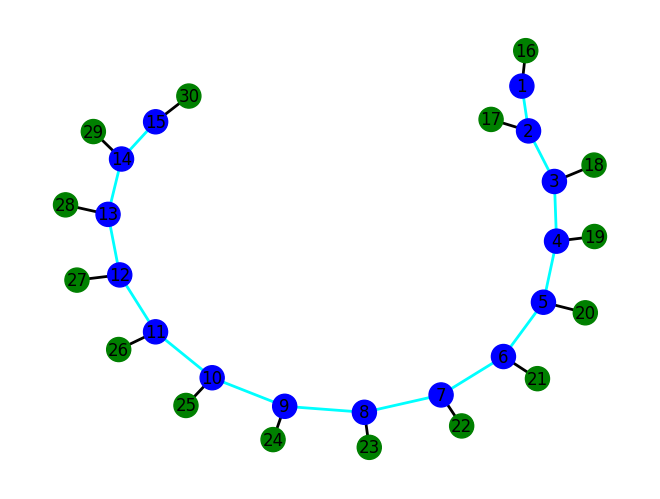

In [68]:
#build the equivalent graph
g = nx.Graph()

# Add main road nodes [1,n] and paths
V = list(range(1,n+1))
g.add_nodes_from(V)
mainPath = list(zip(range(1,n),range(2,n+1)))
g.add_edges_from(mainPath)

# Add deviations [1',n] -> [n+1, n+n] and paths
Vd = list(range(n+1,n+n+1))
g.add_nodes_from(Vd)
deviations = list(zip(range(1,n+1), range(n+1,n+n+1)))
g.add_edges_from(deviations)

# Draw the graph
# Nodes with main road in blue, deviation nodes in green
colors = ["blue"] * n + ["green"] * n
# Main paths in cyan, deviation paths in black
edge_colors = ["cyan", "black"] * (n-1)
edge_colors.append('black')
nx.draw(g, with_labels=True, node_color=colors, edge_color=edge_colors, width=2)


In [69]:
import mip
# Create model
m = mip.Model()

# Variable Definitions
x = [m.add_var(var_type=mip.BINARY) for _ in range(n)] #1 if a recharging station is installed at stop i, 0 otherwise.
b = [m.add_var(lb =0, ub=delta) for _ in range(n)] #Remaining battery mileage at stop i. (before recharge)
ba = [m.add_var(lb =0, ub=delta) for _ in range(n)] #Remaining battery mileage at stop i. (after eventual recharge)

M = 1000 # big-M

# Constraints

# Prevent error in edge-case with empty graph
if n > 0:
    # Starting point constraints: battery full on start -> should force x[0] = 0
    m += b[0] == delta
    m += ba[0] == delta

for i in range(n-1): # Exclude the last station -> just arrive there, no matter with what battery
    #Recharge battery if station is present 
    m += ba[i] <= b[i] + M * x[i]
    m += ba[i] >= b[i] - M * x[i]
    m += ba[i] <= delta + M * (1 - x[i])
    m += ba[i] >= delta - M * (1 - x[i])
    
    # Battery must be enough to reach the next stop
    m += b[i+1] == ba[i] - distStations(i, i+1)


# Objective: Minimize installation cost
m.objective = mip.minimize(mip.xsum(inst_cost[i] * x[i] for i in range(n)))
m.optimize()

Starting solution of the Linear programming relaxation problem using Dual Simplex

Coin0506I Presolve 34 (-38) rows, 26 (-19) columns and 88 (-82) elements
Clp0006I 0  Obj 0 Primal inf 0.259987 (13)
Clp0000I Optimal - objective value 386.2496
Coin0511I After Postsolve, objective 386.2496, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 386.2496 - 20 iterations time 0.002, Presolve 0.00

Starting MIP optimization
Cgl0003I 0 fixed, 0 tightened bounds, 7 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 24 rows, 16 columns (8 integer (8 of which binary)) and 66 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 1.515%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.494443
Cbc0038I Pass   1: suminf.    0.00000 (0) obj

<OptimizationStatus.OPTIMAL: 0>

In [70]:
print(m.objective_value)

12348.0
